# Apprentissage supervisé

### Chargement des packages + données

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import math
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score

In [25]:
folder="C:\\Users\\quentin.mascart\\Documents\\Stage DAM\\CibNav\\"

In [26]:
Data=pd.read_csv(folder+"Données\\Base_complète.csv")

In [27]:
del Data['Nombre Prescriptions Majeurs Hist']
del Data['Nombre Prescriptions Hist']
del Data['Situation Flotteur']

In [28]:
Data=pd.read_csv(folder+"Données\\dataframe.csv")

#Création de la cible au moins une prescription majeure

Data['Cible'] = Data['Nombre Prescriptions Majeurs'].apply(lambda x: '1' if x > 0 else '0').astype(int)
#Création de la cible au moins une préscription majeure ou au moins 4 mineurs
Data['Cible_deux'] = Data['Cible'] + Data['Nombre Prescriptions'].apply(lambda x: '1' if x > 3 else '0').astype(int)
Data['Cible_deux'] = Data['Cible_deux'].apply(lambda x: '1' if x > 0 else '0').astype(int)

del Data['Unnamed: 0']

Verifions la balance des classes cibles

In [29]:
Data['Cible'].sum()/len(Data)

0.40861961274203623

In [30]:
Data['Cible_deux'].sum()/len(Data)

0.5822610868207371

### Création d'une classe pour intégrer les pondérations au gridsearch

Définitions des poids :

In [31]:
lag=max(Data['ID Nav Flotteur'].value_counts())
#Poid logarithmique
#On génère lag-points espacés logarithmiquement de 1 à 10
poids_log=list(np.logspace(0, 1, lag, endpoint=True))[::-1] #Pour décroissant
#Poids arithmétique
Poids_arith=np.arange(lag)[::-1]
#Poids constant pour chaque visite
poids_const= list(np.ones(lag))[::-1]
#On ne prend en compte que la dernière visite
poids_prec= list(np.zeros(lag))[::-1]
poids_prec[0]=1.0

Définition de la fonction de pondération :
On applique un poids à chaque visite d'un bateau

In [32]:
def pondération(data,poids,variable,unite):
    """Cette fonction permet de selectionner un vecteur et de pondérer son historique en fonction
    de poids."""
    df= data.copy(deep=True)#On copie pour ne pas modifier directement notre Dataframe
    df["nom"]=0

    for i in range(0,len(poids)): #On boucle sur l'historique et on affecte un poids a chaque visite antérieure
        df["poids"]=poids[i]*df.groupby([unite])[variable].shift(i+1)
        df['nom'] = df.fillna(0)['nom'] + df.fillna(0)["poids"]
        
    del (df['poids'])
    df[variable]=df['nom']
    del (df['nom'])
    
    return(df)

Pond est une classe- qui permet d'affecter une pondération a un dataFrame pour l'intégrer dans le gridsearch.

In [33]:
class Pond(BaseEstimator, TransformerMixin):
    """Cette classe permet de créer une fonction de 
    pondération d'un attribut d'un dataframe
    - sa fonction de poids
    - les variables à considérer
    """
    def __init__(self,feature_names='Nombre Prescriptions',poids=poids_log):
        self.feature_names= feature_names
        self.poids= poids
            
    def fit(self,X, y=None):
        return self
            
    def transform(self, X, y=None):
        X_= X.copy()
        df=pondération(Data,self.poids,self.feature_names,'ID Nav Flotteur')
        X_.loc[:,self.feature_names]=df.loc[df.index.isin(X_.index), self.feature_names]
        return X_

## Train/Test

Ici nous créons une base de test/train de façon a ne pas utiliser des données 'du futur' pour prédire le passé.

##### Cible = au moins une prescription majeure

In [34]:
test_size=0.33
df=Data.copy()
df=df.sort_values(by='Date Visite')
del df["Date Visite"]
int(len(Data)*test_size)
X_train=df.head(int(len(Data)*(1-test_size))).sample(frac=1)
X_test=df.tail(int(len(Data)*(test_size))).sample(frac=1)

Y_train=X_train['Cible']
Y_test=X_test['Cible']

del X_train['Cible']
del X_test['Cible']
del X_train['Cible_deux']
del X_test['Cible_deux']

##### Cible = au moins une prescription majeure ou au moins 4 Prescriptions mineures 

In [3]:
test_size=0.33
df=Data.copy()
df=df.sort_values(by='Date Visite')
del df["Date Visite"]
int(len(Data)*test_size)
X_train=df.head(int(len(Data)*(1-test_size))).sample(frac=1)
X_test=df.tail(int(len(Data)*(test_size))).sample(frac=1)

Y_train=X_train['Cible_deux']
Y_test=X_test['Cible_deux']

del X_train['Cible']
del X_test['Cible']
del X_train['Cible_deux']
del X_test['Cible_deux']

NameError: name 'Data' is not defined

In [43]:
print(Y_train.sum()/len(Y_train))
print(Y_test.sum()/len(Y_test))

0.5486901438694438
0.5310660562459124


In [37]:
len(X_train)

10726

In [36]:
len(X_test)

5283

# Classification


### Regression logistique

#### Modèle par défaut

In [19]:
pipe = Pipeline([('pondération1',Pond("Nombre Prescriptions",poids_log)),('pondération2',Pond("Nombre Prescriptions Majeurs",poids_log)),('scaler', RobustScaler()), ('logreg', LogisticRegression(max_iter=5000))])
pipe.fit(X_train, Y_train.values.ravel())

Pipeline(steps=[('pondération1', Pond()),
                ('pondération2',
                 Pond(feature_names='Nombre Prescriptions Majeurs')),
                ('scaler', RobustScaler()),
                ('logreg', LogisticRegression(max_iter=5000))])

Affichons les coefficients de la regression logisitiques

In [54]:
Coef=pd.DataFrame()
Coef['nom']=X_train.columns
Coef['coef']=pipe.named_steps['logreg'].coef_.ravel()#.ravel permet de flatten l'array.
Coef

,nom,coef
0,ID Nav Flotteur,0.002142
1,Jauge Oslo,-0.026224
2,Longueur Hors Tout,0.390910
3,Nombre Moteur,-0.223852
4,Num Version,0.275023
5,Puissance Administrative,-0.097260
6,Nombre Prescriptions,0.208309
7,Nombre Prescriptions Majeurs,0.052390
8,Sitrep History,0.053154
9,Sitrep History.1,0.053154


Matrice de confusion

In [20]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, pipe.predict(X_test))
cf = pd.DataFrame(conf, columns=['prédit ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']])
cf.index = ['vrai ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']]
cf

,prédit Prescription majeure,prédit Pas de prescription majeure
vrai Prescription majeure,700,1555
vrai Pas de prescription majeure,440,2588


In [55]:
balanced_accuracy_score(pipe.predict(X_test),Y_test)

0.6199108832907758

#### Gridsearch logistique

Etude des différents poids

In [128]:
pipe = Pipeline([('pondération1',Pond("Nombre Prescriptions",poids_log)),('pondération2',Pond("Nombre Prescriptions Majeurs",poids_log)),('scaler', RobustScaler()), ('logreg', LogisticRegression(max_iter=5000))])
parameters = {
    'pondération1__poids':[poids_log,Poids_arith,poids_const,poids_prec],
    'pondération2__poids':[poids_log,Poids_arith,poids_const,poids_prec],
             } # defining parameter space
balanced_scorer = make_scorer(balanced_accuracy_score)

clf = GridSearchCV(pipe, parameters, cv=3,scoring=balanced_scorer)
clf.fit(X_train, Y_train.values.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pondération1', Pond()),
                                       ('pondération2',
                                        Pond(feature_names='Nombre '
                                                           'Prescriptions '
                                                           'Majeurs')),
                                       ('scaler', RobustScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=5000))]),
             param_grid={'pondération1__poids': [[10.0, 6.309573444801933,
                                                  3.981071705534973,
                                                  2.51188643150958,
                                                  1.5848931924611136, 1.0],
                                                 array([5, 4, 3, 2, 1, 0]),
                                                 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   

In [129]:
print('Returned hyperparameter: {}'.format(clf.best_params_))

Returned hyperparameter: {'pondération1__poids': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'pondération2__poids': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


In [130]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, clf.predict(X_test))
cf = pd.DataFrame(conf, columns=['prédit ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']])
cf.index = ['vrai ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']]
cf

,prédit Prescription majeure,prédit Pas de prescription majeure
vrai Prescription majeure,548,1616
vrai Pas de prescription majeure,366,2681


In [131]:
balanced_accuracy_score(clf.predict(X_test),Y_test)

0.6117430154568171

### Arbre de décision

Quelle profondeur ?

In [132]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('pondération1',Pond("Nombre Prescriptions",poids_log)),('pondération2',Pond("Nombre Prescriptions Majeurs",poids_log)),('scaler', RobustScaler()), ('RF', RandomForestClassifier())])
parameters2 = {'RF__max_depth': [6,10,15,20]} # defining parameter space
balanced_scorer = make_scorer(balanced_accuracy_score)

clf2 = GridSearchCV(pipe, parameters2, cv=3,scoring=balanced_scorer)
clf2.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pondération1', Pond()),
                                       ('pondération2',
                                        Pond(feature_names='Nombre '
                                                           'Prescriptions '
                                                           'Majeurs')),
                                       ('scaler', RobustScaler()),
                                       ('RF', RandomForestClassifier())]),
             param_grid={'RF__max_depth': [6, 10, 15, 20]},
             scoring=make_scorer(balanced_accuracy_score))

In [133]:
print('Returned hyperparameter: {}'.format(clf.best_params_))

Returned hyperparameter: {'pondération1__poids': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'pondération2__poids': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}
Best classification accuracy in train is: 0.5901986134915161
Classification accuracy on test is: 0.5665583007315459


In [134]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, clf2.predict(X_test))
cf = pd.DataFrame(conf, columns=['prédit ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']])
cf.index = ['vrai ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']]
cf

,prédit Prescription majeure,prédit Pas de prescription majeure
vrai Prescription majeure,910,1254
vrai Pas de prescription majeure,641,2406


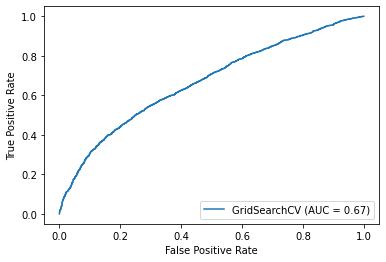

In [135]:
balanced_accuracy_score(clf2.predict(X_test),Y_test)

In [136]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('pondération1',Pond("Nombre Prescriptions",poids_log)),('pondération2',Pond("Nombre Prescriptions Majeurs",poids_log)),('scaler', RobustScaler()), ('RF', RandomForestClassifier())])
parameters2 = {
    'pondération1__poids':[poids_log,Poids_arith,poids_const,poids_prec],
    'pondération2__poids':[poids_log,Poids_arith,poids_const,poids_prec],
    'RF__max_depth': [6,10,15,20]} # defining parameter space
balanced_scorer = make_scorer(balanced_accuracy_score)
clf3 = GridSearchCV(pipe, parameters2, cv=3,scoring=balanced_scorer)
clf3.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pondération1', Pond()),
                                       ('pondération2',
                                        Pond(feature_names='Nombre '
                                                           'Prescriptions '
                                                           'Majeurs')),
                                       ('scaler', RobustScaler()),
                                       ('RF', RandomForestClassifier())]),
             param_grid={'RF__max_depth': [6, 10, 15, 20],
                         'pondération1__poids': [[10.0, 6.309573444801933,
                                                  3.981071705534973,
                                                  2.51188643150958,
                                                  1.5848931924611136, 1.0],
                                                 array([5, 4, 3, 2, 1, 0]),
                                                 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [137]:
print('Returned hyperparameter: {}'.format(clf3.best_params_))

Returned hyperparameter: {'RF__max_depth': 20, 'pondération1__poids': [10.0, 6.309573444801933, 3.981071705534973, 2.51188643150958, 1.5848931924611136, 1.0], 'pondération2__poids': [10.0, 6.309573444801933, 3.981071705534973, 2.51188643150958, 1.5848931924611136, 1.0]}


In [138]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, clf3.predict(X_test))
cf = pd.DataFrame(conf, columns=['prédit ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']])
cf.index = ['vrai ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']]
cf

,prédit Prescription majeure,prédit Pas de prescription majeure
vrai Prescription majeure,918,1246
vrai Pas de prescription majeure,633,2414


In [140]:
balanced_accuracy_score(clf3.predict(X_test),Y_test)

0.6117430154568171

In [141]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('pondération1',Pond("Nombre Prescriptions",Poids_arith)),('pondération2',Pond("Nombre Prescriptions Majeurs",Poids_arith)),('scaler', RobustScaler()), ('RF', RandomForestClassifier())])
param_grid = {
    'pondération1__poids':[poids_log,Poids_arith,poids_const,poids_prec],
    'pondération2__poids':[poids_log,Poids_arith,poids_const,poids_prec],
    'RF__bootstrap': [True],
    'RF__max_depth': [80, 90, 100, 110],
    'RF__max_features': [2, 3],
    'RF__min_samples_leaf': [3, 4, 5],
    'RF__min_samples_split': [8, 10, 12],
    'RF__n_estimators': [100, 200, 300, 1000]
}
balanced_scorer = make_scorer(balanced_accuracy_score)
clf4 = GridSearchCV(pipe, parameters2, cv=3,scoring=balanced_scorer)
clf4.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pondération1',
                                        Pond(poids=array([5, 4, 3, 2, 1, 0]))),
                                       ('pondération2',
                                        Pond(feature_names='Nombre '
                                                           'Prescriptions '
                                                           'Majeurs',
                                             poids=array([5, 4, 3, 2, 1, 0]))),
                                       ('scaler', RobustScaler()),
                                       ('RF', RandomForestClassifier())]),
             param_grid={'RF__max_depth': [6, 10, 15, 20],
                         'pondération1__poids': [[10.0, 6.309573444801933,
                                                  3.981071705534973,
                                                  2.51188643150958,
                                                  1.5848931924611136, 1.0],
     

In [1]:
print('Returned hyperparameter: {}'.format(clf4.best_params_))

NameError: name 'clf4' is not defined

In [142]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, clf4.predict(X_test))
cf = pd.DataFrame(conf, columns=['prédit ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']])
cf.index = ['vrai ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']]
cf

,prédit Prescription majeure,prédit Pas de prescription majeure
vrai Prescription majeure,895,1269
vrai Pas de prescription majeure,632,2415


In [143]:
balanced_accuracy_score(clf4.predict(X_test),Y_test)

0.6208270138591135

### Testons aussi des réseaux de neurones

In [144]:
from sklearn.neural_network import MLPClassifier

In [146]:
pipe = Pipeline([('pondération1',Pond("Nombre Prescriptions",Poids_arith)),('pondération2',Pond("Nombre Prescriptions Majeurs",Poids_arith)),('scaler', RobustScaler()), ('MLP', MLPClassifier(max_iter=100))])
parameter_space = {
    'MLP__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'MLP__activation': ['tanh', 'relu'],
    'MLP__solver': ['sgd', 'adam'],
    'MLP__alpha': [0.0001, 0.05],
    'MLP__learning_rate': ['constant','adaptive'],
}

balanced_scorer = make_scorer(balanced_accuracy_score)
clf5 = GridSearchCV(pipe, parameter_space, cv=3,scoring=balanced_scorer)
clf5.fit(X_train, Y_train)

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perc

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perc

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perc

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perc

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pondération1',
                                        Pond(poids=array([5, 4, 3, 2, 1, 0]))),
                                       ('pondération2',
                                        Pond(feature_names='Nombre '
                                                           'Prescriptions '
                                                           'Majeurs',
                                             poids=array([5, 4, 3, 2, 1, 0]))),
                                       ('scaler', RobustScaler()),
                                       ('MLP', MLPClassifier(max_iter=100))]),
             param_grid={'MLP__activation': ['tanh', 'relu'],
                         'MLP__alpha': [0.0001, 0.05],
                         'MLP__hidden_layer_sizes': [(50, 50, 50),
                                                     (50, 100, 50), (100,)],
                         'MLP__learning_rate': ['constant', 'adaptive'],
              

In [147]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, clf5.predict(X_test))
cf = pd.DataFrame(conf, columns=['prédit ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']])
cf.index = ['vrai ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']]
cf

,prédit Prescription majeure,prédit Pas de prescription majeure
vrai Prescription majeure,782,1382
vrai Pas de prescription majeure,560,2487


In [148]:
print('Returned hyperparameter: {}'.format(clf5.best_params_))

Returned hyperparameter: {'MLP__activation': 'relu', 'MLP__alpha': 0.0001, 'MLP__hidden_layer_sizes': (100,), 'MLP__learning_rate': 'adaptive', 'MLP__solver': 'adam'}


In [149]:
balanced_accuracy_score(clf5.predict(X_test),Y_test)

0.6127570635788543

### Et des SVM

In [150]:
from sklearn.svm import LinearSVC

In [151]:
# SVM Classifier
pipe = Pipeline([('pondération1',Pond("Nombre Prescriptions",Poids_arith)),('pondération2',Pond("Nombre Prescriptions Majeurs",Poids_arith)),('scaler', RobustScaler()), ('SVC', LinearSVC(max_iter=5000))])
parameter_space = {'SVC__C': np.logspace(-20, 20, 17, base=2)} # defining parameter space
balanced_scorer = make_scorer(balanced_accuracy_score)
clf6 = GridSearchCV(pipe, parameter_space, cv=3,scoring=balanced_scorer)
clf6.fit(X_train, Y_train)

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\quentin.mascart\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\U

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pondération1',
                                        Pond(poids=array([5, 4, 3, 2, 1, 0]))),
                                       ('pondération2',
                                        Pond(feature_names='Nombre '
                                                           'Prescriptions '
                                                           'Majeurs',
                                             poids=array([5, 4, 3, 2, 1, 0]))),
                                       ('scaler', RobustScaler()),
                                       ('SVC', LinearSVC(max_iter=5000))]),
             param_grid={'SVC__C': array([9.53674316e-07, 5.39479661e-06, 3.05175781e-05, 1.72633492e-04,
       9.76562500e-04, 5.52427173e-03, 3.12500000e-02, 1.76776695e-01,
       1.00000000e+00, 5.65685425e+00, 3.20000000e+01, 1.81019336e+02,
       1.02400000e+03, 5.79261875e+03, 3.27680000e+04, 1.85363800e+05,
       1.04857600e+06])},
      

In [152]:
print('Returned hyperparameter: {}'.format(clf6.best_params_))

Returned hyperparameter: {'SVC__C': 5.656854249492381}


In [153]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, clf6.predict(X_test))
cf = pd.DataFrame(conf, columns=['prédit ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']])
cf.index = ['vrai ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']]
cf

,prédit Prescription majeure,prédit Pas de prescription majeure
vrai Prescription majeure,547,1617
vrai Pas de prescription majeure,353,2694


In [154]:
balanced_accuracy_score(clf6.predict(X_test),Y_test)

0.616345395499884

# Comparaison avec le hasard

In [155]:
from sklearn.dummy import DummyClassifier

In [156]:
dummy = Pipeline([('pondération1',Pond("Nombre Prescriptions",poids_log)),('pondération2',Pond("Nombre Prescriptions Majeurs",poids_log)),('scaler', RobustScaler()), ('Dummy', DummyClassifier(strategy='stratified'))])
dummy.fit(X_train, Y_train.values.ravel())

Pipeline(steps=[('pondération1', Pond()),
                ('pondération2',
                 Pond(feature_names='Nombre Prescriptions Majeurs')),
                ('scaler', RobustScaler()),
                ('Dummy', DummyClassifier(strategy='stratified'))])

In [157]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, dummy.predict(X_test))
cf = pd.DataFrame(conf, columns=['prédit ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']])
cf.index = ['vrai ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']]
cf

,prédit Prescription majeure,prédit Pas de prescription majeure
vrai Prescription majeure,840,1324
vrai Pas de prescription majeure,1188,1859


In [158]:
print('Classification accuracy on test is: {}'.format(balanced_accuracy_score(dummy.predict(X_test), Y_test)))

Classification accuracy on test is: 0.49804288155164145


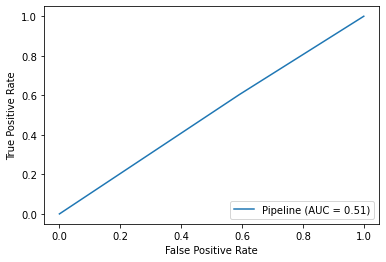

In [159]:
from sklearn.metrics import plot_roc_curve, recall_score, precision_score, roc_auc_score, make_scorer
svc_disp = plot_roc_curve(dummy, X_test, Y_test)
plt.show()

# Graphique

Evaluer le nombre de visite nécessaire au cours d'une année pour detecter toutes les visites sur lesquelles il y a un contrôle majeur

Abscice : nombre de visite anuelle
Ordoné : nb de visite pendant lesquelques une prescription majeure a été émise
l'omnipotant d'abords visite prioritaire. Dummy au pif
CLF en fonction de la priorisation

In [161]:
df_result=pd.DataFrame(Y_test.copy())
df_result['Clf_prediction']=clf.predict(X_test)
df_result['Clf_proba']=clf.predict_proba(X_test)[:,1]
df_result['Dummy_prediction']=dummy.predict(X_test)

In [162]:
df_result.sort_values(by='Clf_proba', ascending=False)

,Cible_deux,Clf_prediction,Clf_proba,Dummy_prediction
8712,1,1,0.994777,0
11704,1,1,0.993541,1
9616,1,1,0.993287,0
11703,1,1,0.991104,0
13011,1,1,0.989597,0
...,...,...,...,...
14711,1,0,0.294994,0
14768,0,0,0.292415,0
11053,0,0,0.292348,0
515,1,0,0.276204,1


In [163]:
df_graph = df_result.copy()

# Abscisses : Nombre de visites anuelles
df_graph = df_graph.reset_index()
df_graph['x_index'] = range(0, len(df_graph))

# Création de la courbe Borne Inférieure - Modèle Dummy
df_graph_inf = df_graph.sample(frac=1)  # Sampling the data so no memory of SVC prediction
df_graph_inf['eval_model'] = df_graph_inf['Cible_deux'].cumsum()

# Création de la courbe Borne Supérieure - Modèle Omnipotent
df_graph_sup = df_graph.sort_values(by='Cible_deux', ascending=False)
df_graph_sup['eval_model'] = df_graph_sup['Cible_deux'].cumsum()

# Creation de la courbe issue de notre modèle
df_algo=df_graph.sort_values(by='Clf_proba', ascending=False)
df_algo['eval_model'] = df_algo['Cible_deux'].cumsum()


In [164]:
import plotly.graph_objects as go

# Create random data with numpy
import numpy as np


# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_graph["x_index"], y=df_graph_sup["eval_model"],
                    mode='lines',
                    name='Borne sup - Omnipotent', line= {"shape": 'hv'},))

fig.add_trace(go.Scatter(x=df_graph["x_index"], y=df_algo["eval_model"],
                    mode='lines',
                    name='Random Forest', line= {"shape": 'hv'},))


fig.add_trace(go.Scatter(x=df_graph["x_index"], y=df_graph_inf["eval_model"],
                    mode='lines',
                    name='Borne Inf - Dummy'))

fig.show()

# Conclusion